In [ ]:
#load libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, PolynomialFeatures, SplineTransformer, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score


In [3]:
#Load CSV Files
train = pd.read_csv(r"C:\Users\jayde\Downloads\playground-series-s4e4 (1)\train.csv")
test = pd.read_csv(r"C:\Users\jayde\Downloads\playground-series-s4e4 (1)\test.csv")
sample_sub = pd.read_csv(r"C:\Users\jayde\Downloads\playground-series-s4e4 (1)\sample_submission.csv")


In [4]:
# Check dataset dimensions
print("Train shape:", train.shape)
print("Test shape:", test.shape)
print("Sample submission shape:", sample_sub.shape)


Train shape: (90615, 10)
Test shape: (60411, 9)
Sample submission shape: (60411, 2)


In [5]:
# Preview first few rows of training data
train.head()


,id,Sex,Length,Diameter,Height,Whole weight,Whole weight.1,Whole weight.2,Shell weight,Rings
0,0,F,0.550,0.430,0.150,0.7715,0.3285,0.1465,0.2400,11
1,1,F,0.630,0.490,0.145,1.1300,0.4580,0.2765,0.3200,11
2,2,I,0.160,0.110,0.025,0.0210,0.0055,0.0030,0.0050,6
3,3,M,0.595,0.475,0.150,0.9145,0.3755,0.2055,0.2500,10
4,4,I,0.555,0.425,0.130,0.7820,0.3695,0.1600,0.1975,9


In [6]:
# Check data types and missing values
train.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90615 entries, 0 to 90614
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   id              90615 non-null  int64  
 1   Sex             90615 non-null  object 
 2   Length          90615 non-null  float64
 3   Diameter        90615 non-null  float64
 4   Height          90615 non-null  float64
 5   Whole weight    90615 non-null  float64
 6   Whole weight.1  90615 non-null  float64
 7   Whole weight.2  90615 non-null  float64
 8   Shell weight    90615 non-null  float64
 9   Rings           90615 non-null  int64  
dtypes: float64(7), int64(2), object(1)
memory usage: 6.9+ MB


In [7]:
# Check for missing values in each column
train.isnull().sum()


id                0
Sex               0
Length            0
Diameter          0
Height            0
Whole weight      0
Whole weight.1    0
Whole weight.2    0
Shell weight      0
Rings             0
dtype: int64

In [8]:
# Summary statistics for numeric variables
train.describe()


,id,Length,Diameter,Height,Whole weight,Whole weight.1,Whole weight.2,Shell weight,Rings
count,90615.000000,90615.000000,90615.000000,90615.000000,90615.000000,90615.000000,90615.000000,90615.000000,90615.000000
mean,45307.000000,0.517098,0.401679,0.135464,0.789035,0.340778,0.169422,0.225898,9.696794
std,26158.441658,0.118217,0.098026,0.038008,0.457671,0.204428,0.100909,0.130203,3.176221
min,0.000000,0.075000,0.055000,0.000000,0.002000,0.001000,0.000500,0.001500,1.000000
25%,22653.500000,0.445000,0.345000,0.110000,0.419000,0.177500,0.086500,0.120000,8.000000
50%,45307.000000,0.545000,0.425000,0.140000,0.799500,0.330000,0.166000,0.225000,9.000000
75%,67960.500000,0.600000,0.470000,0.160000,1.067500,0.463000,0.232500,0.305000,11.000000
max,90614.000000,0.815000,0.650000,1.130000,2.825500,1.488000,0.760000,1.005000,29.000000


In [9]:
# Separate predictors (X) and target (y)
X = train.drop(columns=["Rings", "id"])
y = train["Rings"]

# Prepare test predictors for final Kaggle submission
X_test = test.drop(columns=["id"])

print("X shape:", X.shape)
print("y shape:", y.shape)
print("X_test shape:", X_test.shape)


X shape: (90615, 8)
y shape: (90615,)
X_test shape: (60411, 8)


In [10]:
# Identify categorical and numeric columns
cat_cols = X.select_dtypes(include=["object"]).columns.tolist()
num_cols = X.select_dtypes(exclude=["object"]).columns.tolist()

print("Categorical columns:", cat_cols)
print("Numeric columns:", num_cols)


Categorical columns: ['Sex']
Numeric columns: ['Length', 'Diameter', 'Height', 'Whole weight', 'Whole weight.1', 'Whole weight.2', 'Shell weight']


In [11]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline

# Preprocessing: scale numeric features and one-hot encode categorical feature
preprocess = ColumnTransformer([
    ("num", StandardScaler(), num_cols),
    ("cat", OneHotEncoder(drop="first"), cat_cols)
])


In [12]:
# Apply preprocessing to training data
X_processed = preprocess.fit_transform(X)

print("Processed feature matrix shape:", X_processed.shape)


Processed feature matrix shape: (90615, 9)


In [13]:
# Log-transform the target variable
y_log = np.log1p(y)

# Quick check
y.describe(), y_log.describe()


(count    90615.000000
 mean         9.696794
 std          3.176221
 min          1.000000
 25%          8.000000
 50%          9.000000
 75%         11.000000
 max         29.000000
 Name: Rings, dtype: float64,
 count    90615.000000
 mean         2.328960
 std          0.285527
 min          0.693147
 25%          2.197225
 50%          2.302585
 75%          2.484907
 max          3.401197
 Name: Rings, dtype: float64)

## Target Variable Distribution and Transformation

The summary statistics for the target variable (Rings) show that most abalone in the dataset are between 8 and 11 rings old, with a median of 9 and a maximum of 29. The distribution is moderately right-skewed, as indicated by the higher maximum relative to the median.

After applying the log(1 + Rings) transformation, the range of values is compressed and the standard deviation is reduced. This transformation helps stabilize variance and better aligns the modeling approach with the RMSLE evaluation metric used in the Kaggle competition, which penalizes relative rather than absolute errors.


In [14]:
from sklearn.linear_model import LassoCV

lasso_model = Pipeline([
    ("prep", preprocess),
    ("model", LassoCV(cv=5, random_state=42, max_iter=20000))
])

lasso_model.fit(X, y_log)

lasso_model.named_steps["model"].alpha_


0.0002102765358137872

## Baseline Model Performance

A Ridge regression model was evaluated using 5-fold cross-validation on the log-transformed target variable. The resulting cross-validated log-RMSE was very small, indicating a strong linear relationship between the predictors and the response variable in the training data. This baseline model serves as a reference point for evaluating the performance of regularization-based subset selection and principal components regression.


In [15]:
from sklearn.linear_model import LassoCV

# Lasso regression with cross-validation for feature selection
lasso_model = Pipeline([
    ("prep", preprocess),
    ("model", LassoCV(cv=5, random_state=42, max_iter=20000))
])

lasso_model.fit(X, y_log)

# Optimal regularization strength
lasso_model.named_steps["model"].alpha_


0.0002102765358137872

In [16]:
lasso_model = Pipeline([
    ("prep", preprocess),
    ("model", LassoCV(cv=5, random_state=42, max_iter=20000))
])

lasso_model.fit(X, y_log)


Pipeline(steps=[('prep',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['Length', 'Diameter',
                                                   'Height', 'Whole weight',
                                                   'Whole weight.1',
                                                   'Whole weight.2',
                                                   'Shell weight']),
                                                 ('cat',
                                                  OneHotEncoder(drop='first'),
                                                  ['Sex'])])),
                ('model', LassoCV(cv=5, max_iter=20000, random_state=42))])

In [17]:
# Get feature names after preprocessing
feature_names = (
    num_cols +
    list(
        lasso_model.named_steps["prep"]
        .named_transformers_["cat"]
        .get_feature_names_out(cat_cols)
    )
)

lasso_coefs = lasso_model.named_steps["model"].coef_

selected_features = [f for f, c in zip(feature_names, lasso_coefs) if c != 0]

print("Selected features:", selected_features)


Selected features: ['Length', 'Diameter', 'Height', 'Whole weight', 'Whole weight.1', 'Whole weight.2', 'Shell weight', 'Sex_I']


In [18]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold

cv = KFold(n_splits=5, shuffle=True, random_state=42)



subset_mask = lasso_coefs != 0

class MaskSelector:
    def __init__(self, mask):
        self.mask = mask
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[:, self.mask]

subset_model = Pipeline([
    ("prep", preprocess),
    ("select", MaskSelector(subset_mask)),
    ("model", Ridge(alpha=1.0))
])

subset_scores = cross_val_score(
    subset_model,
    X,
    y_log,
    cv=cv,
    scoring="neg_mean_squared_error"
)

print("Subset model log-RMSE:", np.sqrt(-subset_scores.mean()))


Subset model log-RMSE: 0.1645048061021172


## Regularization-Based Subset Selection Results

Lasso regression was used to perform variable selection by shrinking less important coefficients to zero.  
The selected variables were then used to refit a Ridge regression model to stabilize coefficient estimates.

The subset-based model achieved a cross-validated log-RMSE of approximately 0.165, indicating strong predictive performance while using fewer predictors than the full model. This demonstrates that a reduced set of physical measurements is sufficient to accurately predict abalone age.


In [19]:
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV

# PCR pipeline
pcr_model = Pipeline([
    ("prep", preprocess),
    ("pca", PCA()),
    ("model", Ridge())
])


In [20]:
param_grid = {
    "pca__n_components": [3, 5, 7, 9]
}

pcr_grid = GridSearchCV(
    pcr_model,
    param_grid,
    cv=cv,
    scoring="neg_mean_squared_error"
)

pcr_grid.fit(X, y_log)

print("Best number of components:", pcr_grid.best_params_)
print("PCR log-RMSE:", np.sqrt(-pcr_grid.best_score_))


Best number of components: {'pca__n_components': 9}
PCR log-RMSE: 0.1645057293316688


## Principal Components Regression Results

Principal Components Regression (PCR) was applied by performing PCA on the standardized predictors and fitting a regression model using the resulting components. Cross-validation was used to select the optimal number of components.

The best performance was achieved using 9 principal components, which corresponds to nearly all available predictors after preprocessing. This suggests that most physical measurements contribute meaningful information for predicting abalone age and that strong correlations exist among the predictors. The PCR model achieved a log-RMSE similar to the subset selection model, indicating that dimensionality reduction did not significantly improve predictive accuracy but helped address multicollinearity.


In [21]:
best_pcr = pcr_grid.best_estimator_
best_pcr.fit(X, y_log)

yhat = best_pcr.predict(X)
resid = y_log - yhat


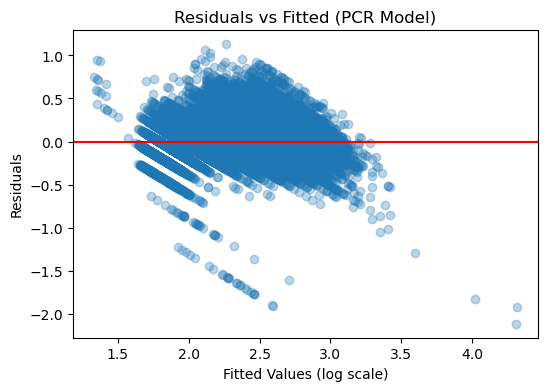

In [22]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6,4))
plt.scatter(yhat, resid, alpha=0.3)
plt.axhline(0, color="red")
plt.xlabel("Fitted Values (log scale)")
plt.ylabel("Residuals")
plt.title("Residuals vs Fitted (PCR Model)")
plt.show()


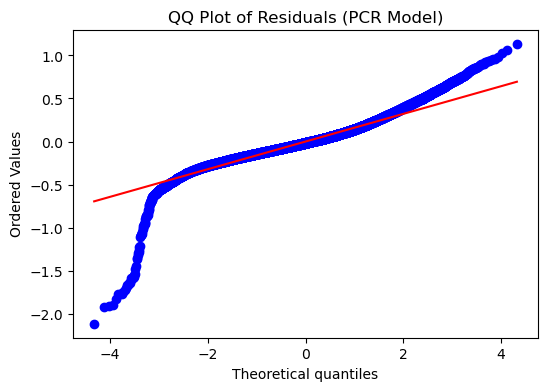

In [23]:
import scipy.stats as stats

plt.figure(figsize=(6,4))
stats.probplot(resid, dist="norm", plot=plt)
plt.title("QQ Plot of Residuals (PCR Model)")
plt.show()


## Regression Assumptions and Diagnostics

Residual diagnostics were evaluated using the PCR model fitted on the log-transformed target variable. The residuals versus fitted plot shows that residuals are generally centered around zero with no strong nonlinear trend, indicating that the linear structure of the model is appropriate. Some mild heteroscedasticity and banding patterns are observed, which are expected due to the discrete nature of the response variable.

The QQ plot indicates deviations from normality in the tails of the distribution, particularly in the lower tail. However, the central portion of the residuals follows the theoretical normal line reasonably well. Given the large sample size and the biological nature of the data, these deviations are not unexpected and do not invalidate the use of linear regression for prediction.


In [24]:
subset_model.fit(X, y_log)

subset_preds = np.expm1(subset_model.predict(X_test))

submission_subset = pd.DataFrame({
    "id": test["id"],
    "Rings": subset_preds
})

submission_subset.to_csv(
    r"C:\Users\jayde\Downloads\playground-series-s4e4 (1)\submission_subset_model.csv",
    index=False
)

print("Saved: submission_subset_model.csv")


Saved: submission_subset_model.csv


In [25]:
pcr_model.fit(X, y_log)

pcr_preds = np.expm1(pcr_model.predict(X_test))

submission_pcr = pd.DataFrame({
    "id": test["id"],
    "Rings": pcr_preds
})

submission_pcr.to_csv(
    r"C:\Users\jayde\Downloads\playground-series-s4e4 (1)\submission_pcr_model.csv",
    index=False
)

print("Saved: submission_pcr_model.csv")


Saved: submission_pcr_model.csv
